In [14]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
import torch
# from tqdm import tqdm
from torch_geometric.utils import to_networkx
import networkx as nx
from gnn import GNN
import matplotlib.pyplot as plt
import os
import numpy as np
from gnn import GNN
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.data import Data, Batch
import plotly.express as px
import matplotlib.colors as mcolors
import random
import pickle
from utils import draw_graph
import plotly.graph_objects as go

if not os.path.isdir("figures"): os.mkdir("figures")

In [15]:
atom_indices = {
    0: "C",
    1: "N",
    2: "O",
    3: "F",
    4: "I",
    5: "Cl",
    6: "Br",
}

edge_indices = {
    0: "aromatic",
    1: "single",
    2: "double",
    3: "triple",
}

atom_colors = {
    0: "#9b5fe0",
    1: "#16a4d8",
    2: "#60dbe8",
    3: "#efdf48",
    4: "#f9a52c",
    5: "#d64e11",
    6: "#8bd346",
}

dataset = TUDataset(root='data/TUDataset', name='MUTAG')
loader = DataLoader(dataset, batch_size=64)
molecules = True
model_path = "models/MUTAG_model.pth"

In [16]:
# with open("data/OurMotifs/dataset.pkl", "rb") as f:
#     dataset = pickle.load(f)
# molecules = False
# model_path = "models/OurMotifs_model_mean.pth"

In [17]:
num_node_features = dataset[0].x.shape[1]
node_colors = {i:c for i,c in enumerate(random.choices(list(mcolors.CSS4_COLORS.values()), k=num_node_features))}
node_colors

{0: '#FFA07A',
 1: '#F5F5DC',
 2: '#FFF0F5',
 3: '#8A2BE2',
 4: '#5F9EA0',
 5: '#F0E68C',
 6: '#4169E1'}

In [18]:
nn = torch.load(model_path)
nn.double()
nn.eval()

GNN(
  (layers): ModuleDict(
    (Conv_0): SAGEConv(7, 32, aggr=mean)
    (Conv_0_Relu): ReLU()
    (Conv_1): SAGEConv(32, 32, aggr=mean)
    (Conv_1_Relu): ReLU()
    (Conv_2): SAGEConv(32, 32, aggr=mean)
    (Conv_2_Relu): ReLU()
    (Aggregation): MeanAggregation()
    (Lin_0): Linear(in_features=32, out_features=32, bias=True)
    (Lin_0_Relu): ReLU()
    (Output): Linear(in_features=32, out_features=2, bias=True)
  )
  (softmax): Softmax(dim=0)
)

NN output given explanation [-17.64548978  20.14174352]


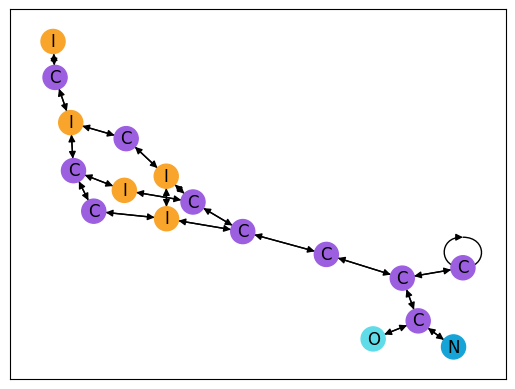

In [37]:
index = "Final"
A = np.load(f"./solutions/A_{index}.npy")
X = np.load(f"./solutions/X_{index}.npy")

fig, _ = draw_graph(A, X, label_dict=(atom_indices if molecules else None), color_dict=(atom_colors if molecules else None))
fig.show()

exp_output = nn.forwardXA(X, A).detach().numpy().squeeze()
print("NN output given explanation", exp_output)


In [20]:
plt.close()

In [36]:
all_outputs = []
max_output_value, min_output_value = None, None
max_activation_value = -float("inf")
for i, data in enumerate(dataset):
    data.x = data.x.double()
    outputs = nn(data).detach().numpy()
    if outputs[0][0] < -15: print(i)
    all_outputs.append(outputs)
    if max_output_value is None: max_output_value, min_output_value = -float("inf")*np.ones_like(outputs), float("inf")*np.ones_like(outputs)
    max_output_value = np.max(np.stack([max_output_value, outputs]),axis=0)
    min_output_value = np.min(np.stack([min_output_value, outputs]),axis=0)

    all_activations = [output for _, output in nn.get_all_layer_outputs(data)]
    max_activation_value = max(max_activation_value, max(float(torch.max(torch.abs(activation))) for activation in all_activations))
print("Max Absolute Activation Value:", max_activation_value)
print("Min Class Output Value:", min_output_value)
print("Max Class Output Value:", max_output_value)
    


all_outputs = np.concatenate(all_outputs, axis=0)
for i in range(all_outputs.shape[-1]):
    fig = px.histogram(all_outputs[:, i], title=f"Class {i} Logit Distribution", color=[int(d.y) for d in dataset], color_discrete_map={0: "Red", 1: "Blue"})

    fig.add_annotation(
        text="Explanation Value",
        x=exp_output[i],
        y=0,  # Adjust the y-coordinate as needed
        showarrow=True,
        arrowhead=2,
        ax=0,  # Adjust the text label's position relative to the point
    )

    fig.update_layout(
        xaxis_title="Logit Value",
        yaxis_title="Count",
    )

    fig.update_xaxes(
        range=[min(min(all_outputs[:, i]), exp_output[i])-2, max(max(all_outputs[:, i]), exp_output[i])+2]
    )    

    fig.show()

Max Absolute Activation Value: 85.14530396702538
Min Class Output Value: [[ -3.89901662 -16.48418655]]
Max Class Output Value: [[13.57019324  3.35013878]]


In [38]:
folder = "figures"
for i in range(14):
    A = np.load(f"./solutions/A_{i}.npy")
    X = np.load(f"./solutions/X_{i}.npy")

    fig, _ = draw_graph(A, X, label_dict=(atom_indices if molecules else None), color_dict=(atom_colors if molecules else None))
    
    plt.savefig(folder + "/file%02d.png" % i)
    plt.close()

import subprocess
import glob
os.chdir(folder)
subprocess.call([
    'ffmpeg', '-framerate', '4', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', '-y',
    'graph_steps.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)
os.chdir("..")

ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvo